In [8]:
import numpy as np

from sigvisa import Sigvisa
from sigvisa.source.event import get_event
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, do_coarse_to_fine, initialize_sg, initialize_from, do_inference
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov
from sigvisa.signals.io import load_event_station_chan

from sigvisa.utils.geog import dist_km_ev

import os, sys, traceback
import cPickle as pickle

stas = ['ASAR', 'KURK', 'MKAR', 'SONM', 'BVAR', 'FITZ', 'CTA', 'CMAR', 'WRA', 'ZALV', 'MJAR', 'AKTO', 'INK']

evids = [5334501, 5334991, 5334726, 5335144, 5349684, 5335822, 5334971, 5349536, 5335079, 5335116, 5335138, 5350499, 5336237, 5335425, 5335424, 5349441, 5336640, 5335577, 5350077, 5336889, 5335760,\
 5336967, 5337111, 5337461, 5351821, 5351657, 5336724, 5351713, 5338302, 5338318, 5338388, 5334939] 

# removed to unclutter visualization: 5348178, 5336015

dbl1 = 9 #6
dbl2 = 17 #32
from sigvisa.signals.xc import xcorr_valid

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
rs = EventRunSpec(evids=evids, stas=stas, runids=(37,), disable_conflict_checking=True)
ms1 = ModelSpec(template_model_type="param", wiggle_family="iid", max_hz=10.0, phases=["P",], dummy_fallback=True)
ms1.add_inference_round(enable_event_moves=False, enable_event_openworld=False, enable_template_openworld=False, enable_template_moves=True, disable_moves=['atime_xc'])

sg = rs.build_sg(ms1)
initialize_sg(sg, ms1, rs)


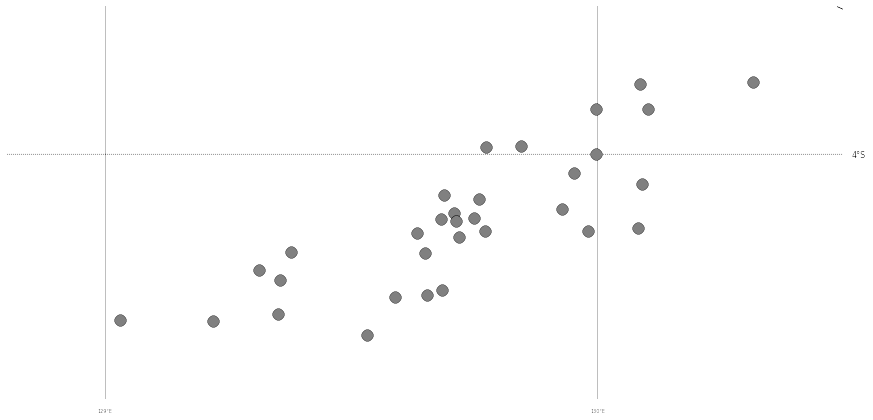

In [143]:

from sigvisa.plotting.event_heatmap import EventHeatmap
from sigvisa.utils.geog import dist_km


hm = EventHeatmap(f=None, left_lon=128.8, right_lon=130.5, bottom_lat=-4.5, top_lat=-3.7, calc=False)

evs = [sg.get_event(eid+1) for eid in range(len(evids))]
locs = [(ev.lon, ev.lat) for ev in evs]
#hm.add_reference_events(locations=ev_locs, covs=ev_covs)

locs_normal = [l for i,l in enumerate(locs) if i+1 != dbl1 and i+1 != dbl1]
loc1 = locs[dbl1-1:dbl1]
loc2 = locs[dbl2-1:dbl2]


def plot_base():
    f = plt.figure(figsize=(15, 15))
    ax = f.add_subplot(111)
    hm.plot(axes=ax, ev_alpha=1.0, colorseed=1)
    hm.plot_locations(locs, marker="o", ms=12,  yvals=None, alpha=1.0, mfc="gray")
    ax.set_title("")
    ax.axis("off")
    return ax, hm

ax, hm = plot_base()
#hm.plot_locations(loc1, marker="*", ms=12,  yvals=None, alpha=1.0, mfc="green")



for eid in [6, 11, 13, 14, 15, 17, 22, 31]:
    ev = sg.get_event(eid)
    if ev.mb < 3.8: continue
    loc = [(ev.lon, ev.lat)]
    ax, hm = plot_base()
    hm.plot_locations(loc, marker="*", ms=12,  yvals=None, alpha=1.0, mfc="green")
    ax.set_title("%d %s" % (eid, loc))

for d in range(len(evids)):
    
    try:
        wn = sg.get_arrival_wn("MK31", d, "P", "freq_0.8_4.5", "BHZ")
        f = plt.figure(figsize=(10,5))
        ax = f.add_subplot(111)
        ax.plot(wn.get_value()[280:420], lw=3, color="blue")
        f.patch.visible=False
        ax.patch.visible=False
        ax.axis('off')
        ax.set_title("%d" % d)
    except:
        continue
#ax.set_ylim([0,20])

def find_doublets():
    signals_mkar = dict()
    for evid in evids:
        w = load_event_station_chan(evid, "MKAR", "BHZ", evtype="leb", pre_s=10, post_s=20, phases=["P"]).filter("freq_0.8_4.5;hz_5.0")
        signals_mkar[evid] = w.data
        #print w['etime'] - w['stime'], len(w.data)


    
    sidx = 125
    eidx = 200
    n = len(evids)
    xcmax1 = np.zeros((n,n))
    offset1 = np.zeros((n,n))
    for i, evid1 in enumerate(evids):
        w1 = signals_mkar[evid1]
        p1 = w1[sidx:eidx]
        for j, evid2 in enumerate(evids):
            w2 = signals_mkar[evid2]
            xcmax1[i,j], offset1[i,j], _ = xcorr_valid(p1, w2)
            if xcmax1[i,j] > 0.65 and evid1 != evid2:
                print evid1, evid2, i+1, j+1, xcmax1[i,j], offset1[i,j], dist_km_ev(sg.get_event(i+1), sg.get_event(j+1))
                figure()
                plot(w1/np.linalg.norm(w1))
                plot(w2/np.linalg.norm(w2))
find_doublets()

In [4]:
w = load_event_station_chan(5335079, "MKAR", "BHZ", evtype="leb", pre_s=10, post_s=20, phases=["P"]).filter("freq_0.8_4.5;hz_10.0")

1240250985.04 1240251015.04


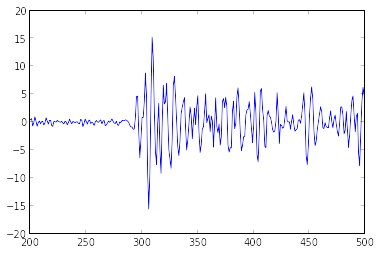

In [5]:
plot(w.data)



evid 5335079.0, loc 129.65 E 4.20 S, depth 0.0km, time 1240250347.8, mb 4.4, natural source
evid 5336640.0, loc 129.63 E 4.16 S, depth 0.0km, time 1240270310.5, mb 4.6, natural source
4.88217728363


(0, 20)

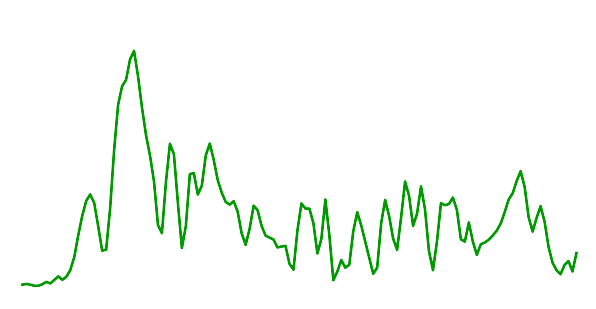

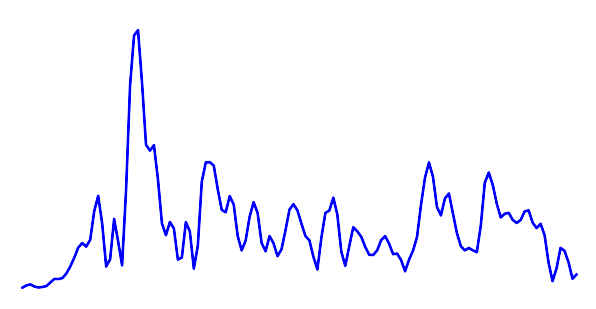

In [9]:
#print sg.extended_evnodes[6]
ev1 = sg.get_event(dbl1)
ev2 = sg.get_event(dbl2)
print ev1
print ev2

print dist_km_ev(ev1, ev2)

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
wn = sg.get_arrival_wn("MK31", dbl1, "P", "freq_0.8_4.5", "BHZ")
ax.plot(wn.get_value()[280:420], lw=3, color="#009900")
f.patch.visible=False
ax.patch.visible=False
ax.axis('off')
ax.set_ylim([0,20])

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
wn = sg.get_arrival_wn("MK31", dbl2, "P", "freq_0.8_4.5", "BHZ")
ax.plot(wn.get_value()[282:422]/1.5, lw=3, color="blue")
f.patch.visible=False
ax.patch.visible=False
ax.axis('off')
ax.set_ylim([0,20])

In [1]:
#do_inference(sg, ms1, rs, max_steps=50)
import cPickle as pickle
with open("/home/dmoore/python/sigvisa/logs/mcmc/01940/step_000049/pickle.sg", 'rb') as f:
    sg = pickle.load(f)

In [4]:
"""
ms2 = ModelSpec(template_model_type="gp_joint",max_hz=10.0, 
                #wiggle_family="db4_2.0_3_30.0", 
                wiggle_family="db4_2.0_3_10.0", 
                wiggle_model_type="gp_joint", 
                inference_preset="closedworld_noatime",
                skip_levels=2)


sg_joint = rs.build_sg(ms2)
initialize_from(sg_joint, ms2, sg, ms1)

print sg_joint.current_log_p()

with open("/home/dmoore/python/sigvisa/logs/mcmc/01940/step_000049/pickle_joint_10s.sg", 'wb') as f:
    pickle.dump(sg_joint, f)
"""

with open("/home/dmoore/python/sigvisa/logs/mcmc/01940/step_000049/pickle_joint.sg", 'rb') as f:
    sg_joint = pickle.load(f)
print sg_joint.current_log_p()

-985338.464539


/home/dmoore/python/sigvisa/models/signal_model.py:572: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return TransientCombinedSSM(components, TSSM_NOISE_PADDING)


In [138]:
hparam_values = {'noise_var': 0.1, 'signal_var': 1.0, 'level_var': 1.0, 
                 'horiz_lscale': 20.0, 'depth_lscale': 200.0}

jgps = sg_joint._joint_gpmodels
for sta in jgps.keys():
    for k in jgps[sta].keys():
        jgp, hnodes = jgps[sta][k]
        for hparam in hnodes.keys():
            hnodes[hparam].set_value(hparam_values[hparam])
sg_joint.current_log_p()

-1013931.973581546

In [148]:
b =  sg_joint.wavelet_basis(10)
sts, ets, ids, M, levels = b
print len(sts)
print levels

sta, chan="AS12", "SHZ"
wn = sg_joint.get_arrival_wn(sta, dbl1, "P", "freq_0.8_4.5", chan)
wn2 = sg_joint.get_arrival_wn(sta, dbl2, "P", "freq_0.8_4.5", chan)

print wn.upwards_message_normalizer()

pm, pv = zip(*[jgp.prior() for jgp in wn.wavelet_param_models["P"]])
d = wn.get_value().data
d2 = wn2.get_value().data

ell, marginals = wn.tssm.all_filtered_cssm_coef_marginals(d)
posterior_means, posterior_vars = marginals[1][0], marginals[1][1]

319
[43, 43, 80, 153]
-18791.8377082


In [140]:
print sta

MK31


In [4]:
ev1 = sg.get_event(9)
from sigvisa.utils.geog import dist_km
print dist_km((ev1.lon, ev1.lat), (129.1, -3.9))

69.7577145256


[[ 129.1   -3.9    0.     0.     0. ]]
[[ 129.65037     -4.2035937    0.           0.           0.       ]]
[[ 129.63363     -4.1629853    0.           0.           0.       ]]
[[ 129.1   -3.9    0.     0.     0. ]]
[[ 129.2334075    -3.96574632    0.            0.            0.        ]]
[[ 129.366815     -4.03149265    0.            0.            0.        ]]
[[ 129.5002225    -4.09723897    0.            0.            0.        ]]
[[ 129.63363     -4.1629853    0.           0.           0.       ]]
hello


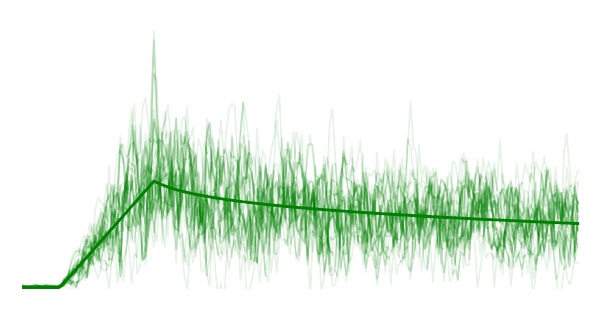

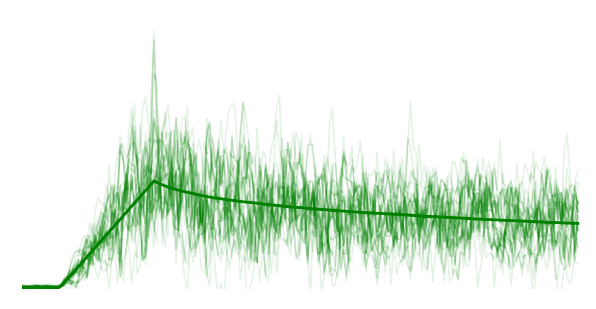

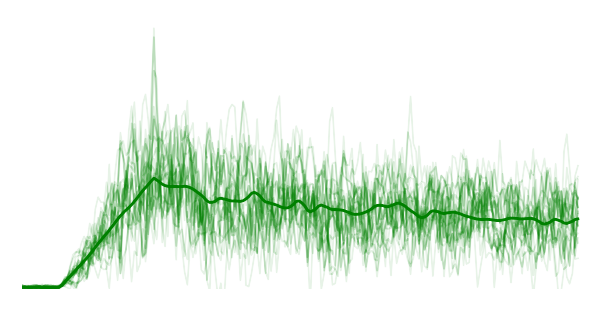

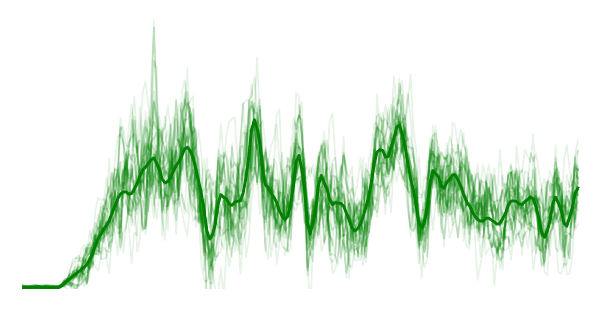

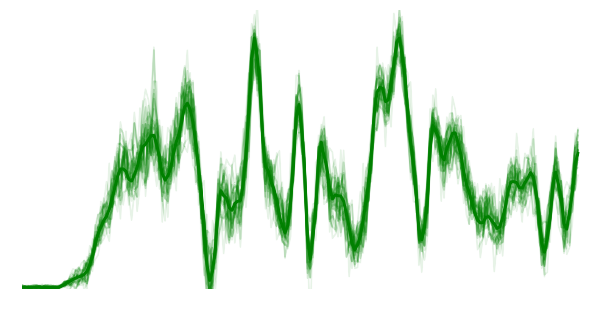

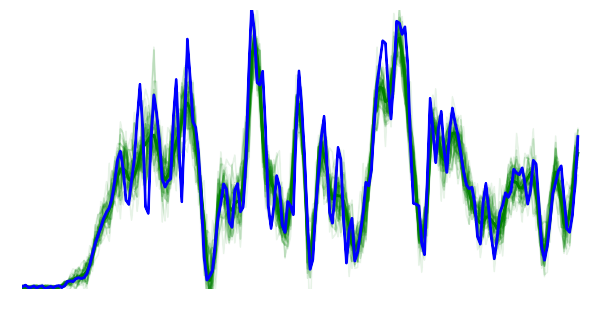

In [151]:
repeatable_cutoff=233

ev1 = sg.get_event(dbl1)
#ev2 = sg.get_event(dbl2)

dbl2 = 17
ev2 = sg.get_event(dbl2)



x = np.array([129.1, -3.9, 0.0, 0, 0]).reshape((1, -1))
x1 = np.array([ev1.lon, ev1.lat, ev1.depth, 0, 0]).reshape((1, -1))
x2 = np.array([ev2.lon, ev2.lat, ev2.depth, 0, 0]).reshape((1, -1))
print x
print x1
print x2

eid_throwaway = 15
wn = sg_joint.get_arrival_wn(sta, dbl2, "P", "freq_0.8_4.5", chan)
cssm = wn.arrival_ssms[(dbl2, "P")]
d = wn.get_value().data


def get_noiseless_posterior(jgp, x, return_gp=False):
    from sigvisa.treegp.gp import GP
    try:
        noise_var, cov = jgp._get_cov()
    except:
        return 0.0, 0.1
    eids, X, y, yvar = jgp._gp_inputs()
    yvar *= 3
    yvar[dbl2-1]/= 3
    gp = GP(X=X, y=y, y_obs_variances=yvar, 
            cov_main=cov, ymean=jgp.ymean, 
            compute_ll=False, 
            sparse_invert=False, 
            noise_var=noise_var, 
            sort_events=False)
    m = gp.predict(x)
    v = gp.variance(x, include_obs=True)
    if return_gp:
        return m, v, gp
    else:
        return m, v

def plot_predicted_envelope(x):
    cm, cv = zip(*[jgp.posterior(holdout_eid=dbl1, x=x) for jgp in wn.wavelet_param_models["P"]])
    cv = np.array(cv, dtype=float)
    repeatable_means = np.concatenate([cm[:-repeatable_cutoff], np.zeros((repeatable_cutoff))])
    repeatable_vars = cv #np.concatenate([cv[:-repeatable_cutoff], np.zeros((repeatable_cutoff))])
    cssm.set_coef_prior(np.array(repeatable_means), np.array(repeatable_vars))



    m = wn.tssm.mean_obs(len(d))
    v = wn.tssm.obs_var(len(d))
    f = plt.figure(figsize=(10, 5))
    ax = f.add_subplot(111)
    #ax.plot(d2[280:420], lw=3)
    #plot(s[280:420])
    #plot(s2[280:420])

    ax.plot(m[280:420], lw=2, color="green")
    #plot(m[280:420]+2*np.sqrt(v[280:420]), lw=1)
    #plot(m[280:420]-2*np.sqrt(v[280:420]), lw=1)
    ax.fill_between(np.arange(420-280), 
                    m[280:420]+2*np.sqrt(v[280:420]), 
                    m[280:420]-2*np.sqrt(v[280:420]), 
                    facecolor="green", alpha=0.4)
def plot_sampled_envelopes(x, n_samples=10):
    
    # how to predict template at a location?
    #ev_tmp = sg_joint.get_event(eid_throwaway)
    #ev_tmp.lon, ev_tmp.lat = x[0,0], x[0,1]
    #sg_joint.set_event(throwaway, ev_tmp)
    #tmnodes = sg_joint.extended_evnodes[throwaway]
    
    #paramm, paramv = zip(*[jgp.posterior(holdout_eid=eid_throwaway, x=x) for jgp in param_jgps])
    #for param, pm in zip(params, paramm):
    #    k, n = tmnodes[param]
    #    n.set_value(key=k, value=pm)
    #pv = wn_throwaway._parent_values()
    #print paramm
    
    

    #wn_throwaway.upwards_message_normalizer()
    #tssm = wn_throwaway.transient_ssm()
    #cssm = wn_throwaway.arrival_ssms[(eid_throwaway, "P")]
    
    tssm = wn.transient_ssm()
    cssm = wn.arrival_ssms[(dbl2, "P")]
    
    cm, cv = zip(*[get_noiseless_posterior(jgp, x=x) for jgp in wn.wavelet_param_models["P"]])
    
    #cm, cv = zip(*[jgp.posterior(holdout_eid=None, x=x) for jgp in wn.wavelet_param_models["P"]])
    cv = np.array(cv, dtype=float)
    
    repeatable_means = np.concatenate([cm[:-repeatable_cutoff], np.zeros((repeatable_cutoff))])
    repeatable_vars = cv #np.concatenate([cv[:-repeatable_cutoff], np.zeros((repeatable_cutoff))])
    cssm.set_coef_prior(np.array(repeatable_means), np.array(repeatable_vars))

    
    f = plt.figure(figsize=(10, 5))
    ax = f.add_subplot(111)
    #ax.plot(d[280:420], lw=3, color='green')
    #ax.plot(d2[282:422]/1.5, lw=3, color='blue')

    for i in range(n_samples):
        s = tssm.prior_sample(len(d), i)
        ax.plot(s[280:480], lw=2, color="green", alpha=0.3)
    m = tssm.mean_obs(len(d))

    ax.plot(m[280:480], lw=3, color="green")
    ax.axis("off")
    ax.set_ylim([0,80])
    return ax

    

for i in range(5):
    alpha = i/4.0
    xx = (1-alpha) * x + alpha * x2
    print xx
    ax = plot_sampled_envelopes(xx, n_samples=20)
    
ax = plot_sampled_envelopes(xx, n_samples=20)
ax.plot(d[280:480], lw=3, color="blue")

print "hello"

In [71]:
jgp = wn.wavelet_param_models["P"][23]
m, v, gp = get_noiseless_posterior(jgp, x1, return_gp=True)

gp.predict(x1)

-3.7960817318649078

In [63]:
print gp.cov_main

se[ 1.], lld[  20.  200.]


-2.6322954375
0.048538800971
-4.21736811007
0.0508677711225


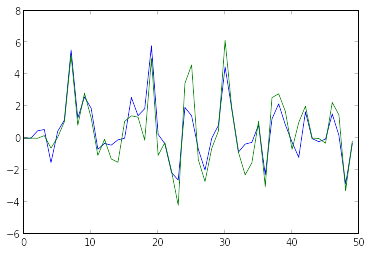

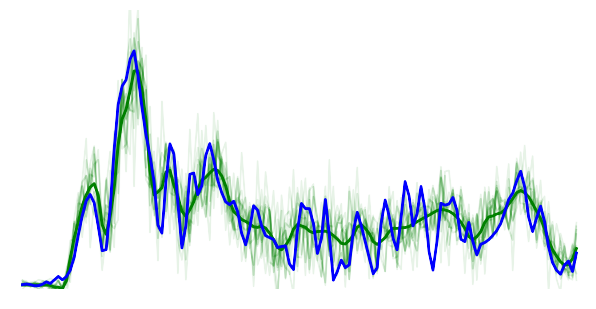

In [91]:
cm, cv = zip(*[jgp.posterior(holdout_eid=None, x=x1) for jgp in wn.wavelet_param_models["P"]])
cv = np.array(cv, dtype=float)
cm = np.array(cm, dtype=float)

tssm = wn.tssm
cssm = wn.arrival_ssms[(dbl1, "P")]
cssm.set_coef_prior(cm, cv)

f = plt.figure(figsize=(10, 5))
ax = f.add_subplot(111)
for i in range(10):
    s = tssm.prior_sample(len(d), i)
    ax.plot(s[280:420], lw=2, color="green", alpha=0.3)
m = tssm.mean_obs(len(d))

ax.plot(m[280:420], lw=3, color="green")
ax.axis("off")
ax.set_ylim([0,20])
ax.plot(d[280:420], lw=3, color="blue")


-0.593016622886
0.016408697834
-1.36723192494
0.0159310925904


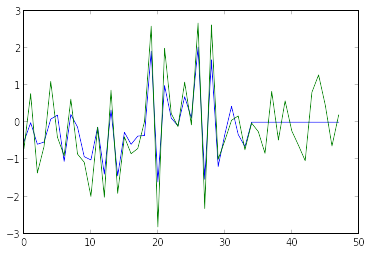

In [97]:
plot(cm[52:100])
plot(posterior_means[52:100])

print cm[54]
print cv[54]
print posterior_means[54]
print posterior_vars[54]

In [98]:
jgp = wn.wavelet_param_models["P"][54]
m, v, gp = get_noiseless_posterior(jgp, x1, return_gp=True)
print m, v
gp.predict(x1)

-0.593016622886 [ 0.01640871]


-0.59301662288558166

[[ 129.1   -3.9    0.     0.     0. ]]
[[ 129.65037     -4.2035937    0.           0.           0.       ]]
[[ 129.63363     -4.1629853    0.           0.           0.       ]]
[[ 129.1   -3.9    0.     0.     0. ]]
[[ 129.2334075    -3.96574632    0.            0.            0.        ]]
[[ 129.366815     -4.03149265    0.            0.            0.        ]]
[[ 129.5002225    -4.09723897    0.            0.            0.        ]]
[[ 129.63363     -4.1629853    0.           0.           0.       ]]


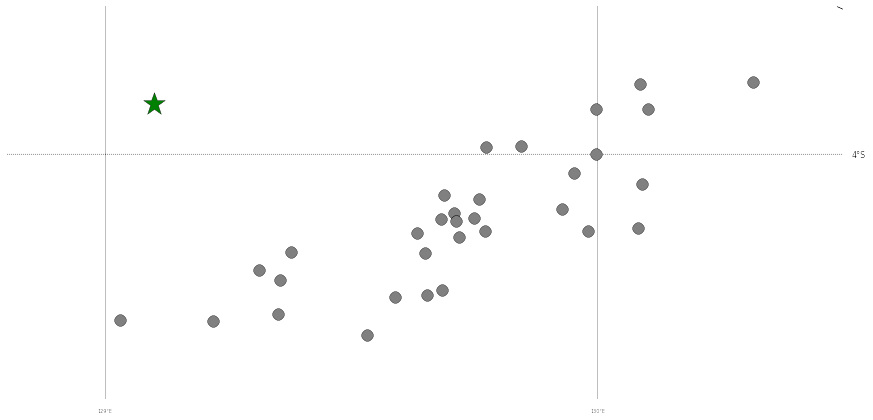

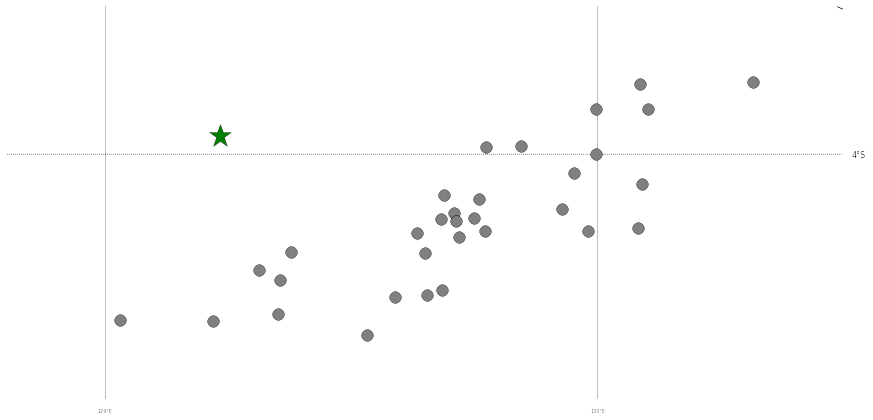

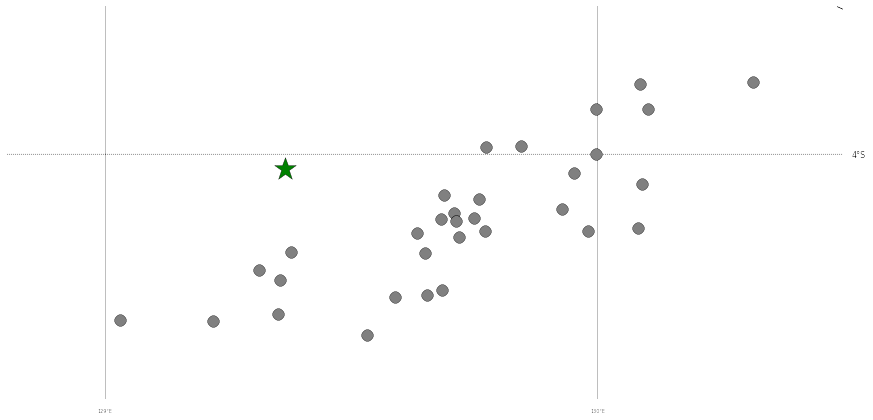

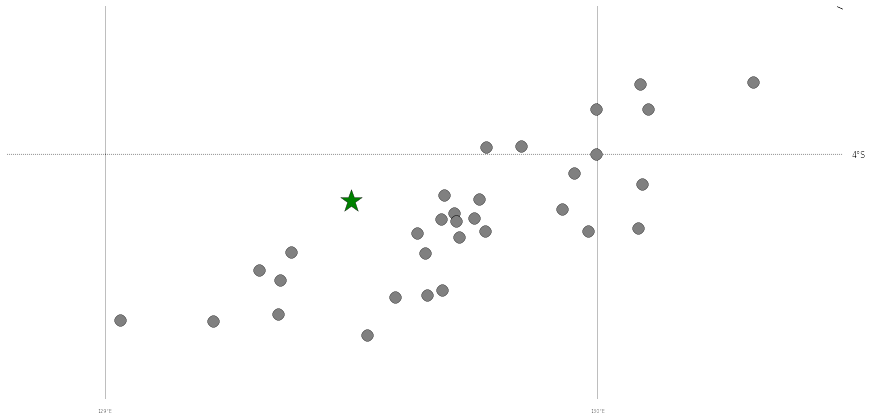

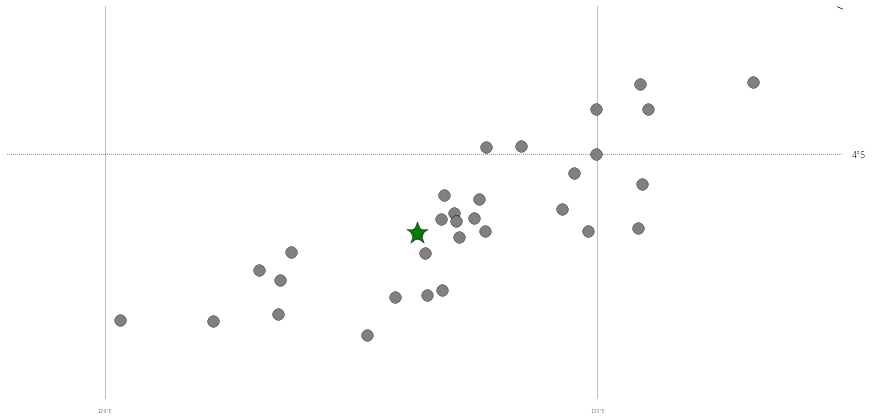

In [145]:
ev1 = sg.get_event(dbl1)
#ev2 = sg.get_event(dbl2)

dbl2 = 17
ev2 = sg.get_event(dbl2)

x = np.array([129.1, -3.9, 0.0, 0, 0]).reshape((1, -1))
x1 = np.array([ev1.lon, ev1.lat, ev1.depth, 0, 0]).reshape((1, -1))
x2 = np.array([ev2.lon, ev2.lat, ev2.depth, 0, 0]).reshape((1, -1))
print x
print x1
print x2

def plot_loc1(xx):
    ax, hm = plot_base()
    hm.plot_locations(xx, marker="*", ms=24,  yvals=None, alpha=1.0, mfc="green")

    
for i in range(5):
    alpha = i/4.0
    xx = (1-alpha) * x + alpha * x2
    print xx
    plot_loc1(xx)



In [7]:
print ev1

evid 5335079.0, loc 129.65 E 4.20 S, depth 0.0km, time 1240250347.8, mb 4.4, natural source


In [5]:
for eid in sg.evnodes.keys():
    if eid!=dbl1:
        #sg.remove_event(eid)
        sg.fix_event(eid)
        sg_joint.fix_event(eid)

rs = EventRunSpec(evids=evids, stas=stas, runids=(37,), disable_conflict_checking=True)
ms_doublet = ModelSpec(template_model_type="param", wiggle_family="iid", max_hz=10.0, phases=["P",])
ms_doublet.add_inference_round(enable_event_moves=True, enable_event_openworld=False, enable_template_openworld=False, enable_template_moves=True, disable_moves=['atime_xc'])
do_inference(sg, ms_doublet, rs, max_steps=5000, model_switch_lp_threshold=-5000)

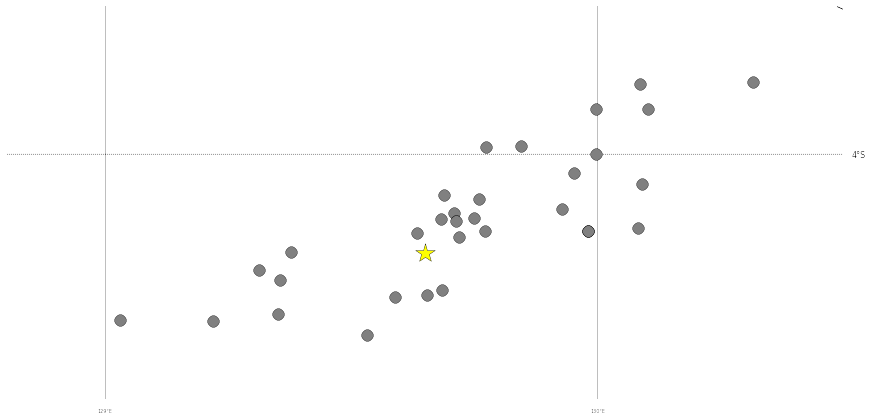

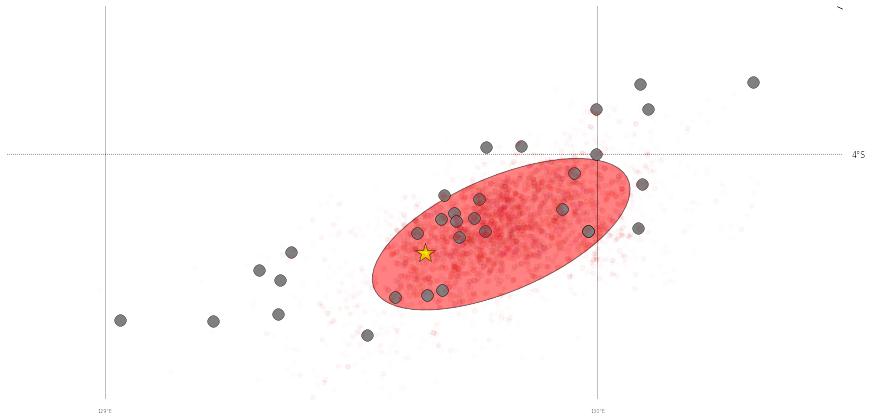

In [159]:
locs = np.loadtxt("/home/dmoore/python/sigvisa/logs/mcmc/01956/ev_00009.txt")[:, 1:3]


def plot_holdout(include_true=False):
    f = plt.figure(figsize=(15, 15))
    ax = f.add_subplot(111)
    hm.plot(axes=ax, ev_alpha=1.0, colorseed=1)
    hm.plot_locations(locs_normal, marker="o", ms=12,  yvals=None, alpha=1.0, mfc="gray")
    if include_true:
        hm.plot_locations(loc1, marker="*", ms=20,  yvals=None, alpha=1.0, mfc="yellow")
    hm.plot_locations(loc2, marker="o", ms=12,  yvals=None, alpha=1.0, mfc="gray")
    ax.set_title("")
    ax.axis("off")
    return ax, hm

ax, hm = plot_holdout(include_true=True)



ax, hm = plot_holdout(include_true=True)
hm.plot_locations(locs, marker=".", ms=10,  yvals=None, alpha=0.1, mfc="red")

stds=3.0
m = np.mean(locs[:, 0:2], axis=0)
centered_trace = locs[:, 0:2] - m
cov = np.dot(centered_trace.T, centered_trace)/float(centered_trace.shape[0])
hm.plot_covs([m,], [cov,], stds=stds, colors=["red",], alpha=0.7)



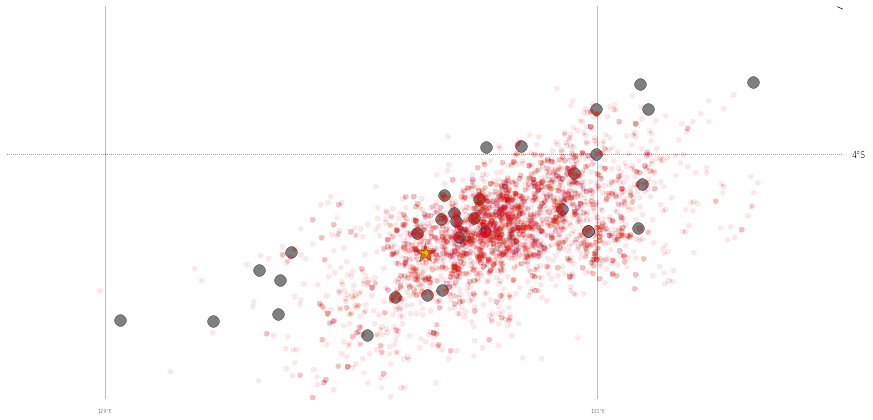

In [160]:
ax, hm = plot_holdout(include_true=True)
hm.plot_locations(locs, marker=".", ms=10,  yvals=None, alpha=0.3, mfc="red")


#with open("/home/dmoore/python/sigvisa/logs/mcmc/01958/step_000000/updated.sg", 'rb') as f:
#    sg_joint = pickle.load(f)

ms2 = ModelSpec(template_model_type="gp_joint",max_hz=10.0, 
                wiggle_family="db4_2.0_3_30.0", 
                wiggle_model_type="gp_joint", 
                skip_levels=2)
for eid in sg_joint.evnodes.keys():
    if eid!=dbl1:
        sg_joint.fix_event(eid)

ms2.add_inference_round(enable_event_moves=False, enable_event_openworld=False, 
                        enable_template_openworld=False, enable_template_moves=True, 
                        enable_hparam_moves=False, disable_moves=['atime_xc'])
ms2.add_inference_round(enable_event_moves=True, enable_event_openworld=False, 
                        enable_template_openworld=False, enable_template_moves=True, 
                        enable_hparam_moves=False, disable_moves=['atime_xc'])
                        
print "running inference"
do_inference(sg_joint, ms2, rs, max_steps=20, model_switch_lp_threshold=-50000, dump_interval=1, print_interval=1)

In [6]:
with open("/home/dmoore/python/sigvisa/logs/mcmc/01958/step_000000/updated.sg", 'wb') as f:
    pickle.dump(sg_joint, f)

In [161]:
with open("/home/dmoore/python/sigvisa/logs/mcmc/01958/step_000000/updated.sg", 'rb') as f:
    sg_joint = pickle.load(f)
print sg_joint.station_waves.keys()

['ZAA0', 'CM16', 'BVA0', 'INK', 'AKTO', 'MK31', 'FITZ', 'CTA', 'WR1', 'SONA0', 'AS12', 'KURBB']
